In [3]:
import os
import openai

In [8]:

# Load your API key from an environment variable or secret management service
# gpt4 只支持ChatCompletion 形式
import os
openai.api_key = os.getenv("OPENAI_API_KEY")

def generate_text(prompt):
    response = openai.Completion.create(
        model="gpt-4",
        prompt=prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    message = response.choices[0].text
    return message.strip()

generate_text('Please give our AI project a name based on what Isaac Asimov calls AI in his Foundation novel, and the name should be concise and smooth.')




InvalidRequestError: 'messages' is a required property

In [9]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai

openai.ChatCompletion.create(
  model="gpt-4",
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"}
    ]
)


<OpenAIObject chat.completion id=chatcmpl-7ACW2qd3YhriLLp3Bakv9xgMBnFqs at 0x7fa6917bdb30> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "The 2020 World Series was played at Globe Life Field in Arlington, Texas. It was the first neutral-site World Series in the modern era due to the COVID-19 pandemic.",
        "role": "assistant"
      }
    }
  ],
  "created": 1682665746,
  "id": "chatcmpl-7ACW2qd3YhriLLp3Bakv9xgMBnFqs",
  "model": "gpt-4-0314",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 37,
    "prompt_tokens": 53,
    "total_tokens": 90
  }
}

# How to build an AI that can answer questions about your website

## Setting up a web crawler

这个爬虫将从下面代码底部传入的根 URL 开始，访问每个页面，找到其他链接，并访问这些页面(只要它们具有相同的根域)。首先，导入所需的包，设置基本 URL，并定义一个 HTMLParser 类。

In [6]:

import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "openai.com" # <- put your domain to be crawled
full_url = "https://openai.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

下一个函数接受 URL 作为参数，打开 URL 并读取 HTML 内容。然后，它返回在该页面上找到的所有超链接。

In [7]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

我们的目标是爬行和索引只在 OpenAI 域下的内容。为此，需要一个函数来调用 get_hyperlinks 函数，过滤掉不属于指定域的任何 URL。

In [8]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

抓取功能是网页抓取任务设置的最后一步。它跟踪访问的 URL，以避免重复相同的页面，这些页面可能在一个站点的多个页面之间链接。它还从不带 HTML 标记的页面中提取原始文本，并将文本内容写入本地。特定于页面的 txt 文件。

In [9]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/blog/new-and-improved-embedding-model
https://openai.com/blog/new-and-improved-embedding-model#ArvindNeelakantan
https://openai.com/blog/new-and-improved-embedding-model#content
https://openai.com/blog?topics=product
https://openai.com/blog/dall-e-now-available-in-beta
https://openai.com/dall-e-2
https://openai.com/research/clip
https://openai.com/research?topics=transfer-learning
https://openai.com/research/efficient-training-of-language-models-to-fill-in-the-middle
https://openai.com/research?authors=nikolas-tezak
https://openai.com/research?authors=heewoo-jun
https://openai.com/research/efficient-training-of-language-models-to-fill-in-the-middle#content
https://openai.com/research?authors=jerry-tworek
https://openai.com/research?authors=christine-mcleavey-payne
https://openai.com/research?authors=mohammad-bavarian
https://openai.com/research?authors=mark-chen
https://openai.com/research?authors=john-schulman-2
https://openai.com/research/econom

KeyboardInterrupt: 

## Building an embeddings index

空白的行可能会使文本文件杂乱无章，使它们更难处理。一个简单的函数可以删除这些行并整理文件。

In [10]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

将文本转换为 CSV 需要遍历前面创建的文本目录中的文本文件。打开每个文件后，删除额外的空格并将修改后的文本附加到列表中。然后，添加文本与新的行删除到一个空的pandas数据框架，并写入数据框架到 CSV 文件。

额外的间距和新的行会使文本杂乱无章，并使嵌入过程复杂化。这里使用的代码有助于删除其中的一些字符，但您可能会发现第三方库或其他方法对于删除更多不必要的字符很有用。

In [11]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

<ipython-input-10-429202555403>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,research?authors=mark chen,research?authors=mark chen. Research index ...
1,research?topics=games,research?topics=games. Research index Close...
2,research?authors=mohammad bavarian,research?authors=mohammad bavarian. Research ...
3,research?topics=transfer learning,research?topics=transfer learning. Research i...
4,research?authors=christine mcleavey payne,research?authors=christine mcleavey payne. Re...


标记化是将原始文本保存到 CSV 文件之后的下一步。这个过程通过分解句子和单词将输入的文本分成标记。在文档中查看我们的 Tokenizer 就可以看到这种情况的可视化演示。

一个有用的经验法则是，一个标记通常对应于普通英语文本的约4个字符。这意味着大约3.4个单词(所以100个标记 ~ = 75个单词)。

API 对用于嵌入的输入标记的最大数量有限制。为了保持在限制之下，需要将 CSV 文件中的文本分解为多行。将首先记录每一行的现有长度，以确定需要拆分哪些行。

<AxesSubplot:>

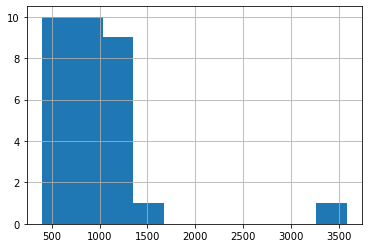

In [13]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

最新的嵌入模型可以处理多达8191个输入标记的输入，因此大多数行不需要任何分块，但是这可能不适用于每一个擦除的子页面，因此下一个代码块将把较长的行分割成较小的块。

In [14]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

再次可视化更新的直方图可以帮助确认行是否成功地分割成缩短的部分。


<AxesSubplot:>

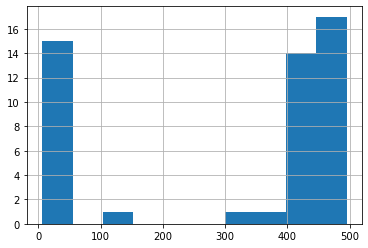

In [15]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

内容现在被分解成更小的块，一个简单的请求可以被发送到 OpenAI API，指定使用新的 text-embedding-ada-002 模型來创建嵌入:


In [49]:
# import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

RateLimitError: Rate limit reached for default-global-with-image-limits in organization org-ez2cbDpVvZsNhsHTSzMToxco on requests per min. Limit: 60 / min. Current: 70 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method.

In [ ]:

def embedding_create(inputs, engine):
    return openai.Embedding.create(input=inputs, engine=engine)['data'][0]['embedding']


df['embeddings'] = df.text.apply(lambda x: )

df.to_csv('processed/embeddings.csv')
df.head()



In [ ]:
根据网络搜索结果，这个报错的意思是您在短时间内发送了太多的请求，超过了OpenAI API的限制。您可以尝试以下几种方法来解决这个问题：

等待一段时间后再重新运行代码。
在您的OpenAI账户中添加付款方式，以提高您的请求限制。
联系support@openai.com寻求帮助。
希望这些信息对您有用




这应该需要大约3-5分钟，但之后，您将有您的嵌入准备使用！

## Building a question answer system with your embeddings

嵌入已经准备好了，这个过程的最后一步是创建一个简单的问答系统。这将采取一个用户的问题，创建它的嵌入，并比较它与现有的嵌入检索最相关的文本从刮网站。然后，text-davinci-003模型将根据检索到的文本生成一个听起来自然的答案。

将嵌入转换为 NumPy 数组是第一步，考虑到操作 NumPy 数组的许多函数，这将为如何使用它提供更大的灵活性。它还将把维度平面化为1-D，这是许多后续操作所需的格式。

In [19]:
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'processed/embeddings.csv'